In [1]:
%%bash
pip3 install 'scikit-learn==0.22.2' sklearn-pandas

You should consider upgrading via the 'pip install --upgrade pip' command.


## Import data

Create a client to the S3 data source.
The access credentials are defined when instatiating JupyterHub.

In [38]:
import boto3
import os
import io

# Configure S3 reading
S3_ENDPOINT_URL = os.environ['S3_ENDPOINT_URL']
S3_ACCESS_KEY = os.environ['AWS_ACCESS_KEY_ID']
S3_SECRET_KEY = os.environ['AWS_SECRET_ACCESS_KEY']

DATA_BUCKET="data"
MODEL_BUCKET="models"

client = boto3.client(
    service_name='s3',
    aws_access_key_id=S3_ACCESS_KEY,
    aws_secret_access_key=S3_SECRET_KEY,
    endpoint_url=S3_ENDPOINT_URL)

Import the dataset directly into a Pandas dataframe and display the 10 first rows.

In [39]:
import pandas as pd

obj = client.get_object(Bucket=DATA_BUCKET, Key="OPEN/uploaded/data.csv")

df = pd.read_csv(io.BytesIO(obj['Body'].read()))

df.head(10)

,Unnamed: 0,age,income,class,response,segment,events
0,0,61,86.321152,0,1,1,6
1,1,56,211.477772,2,0,1,6
2,2,71,219.477410,2,1,2,6
3,3,66,114.392972,0,1,1,2
4,4,27,37.911374,0,0,0,6
5,5,24,37.657855,0,0,0,1
6,6,71,87.220712,0,1,1,1
7,7,25,222.200029,1,1,2,6
8,8,70,194.749676,1,1,2,2
9,9,48,90.640802,0,1,1,5


Describe the (non-categorical) variables.

In [4]:
for var in ['class', 'response', 'segment', 'events']:
    df[var] = df[var].astype('category')
df.describe()

,Unnamed: 0,age,income
count,10000.00000,10000.000000,10000.000000
mean,4999.50000,44.770100,126.154726
std,2886.89568,17.039374,63.518178
min,0.00000,16.000000,16.954413
25%,2499.75000,30.000000,77.360998
50%,4999.50000,45.000000,115.473617
75%,7499.25000,60.000000,164.191913
max,9999.00000,74.000000,507.587347


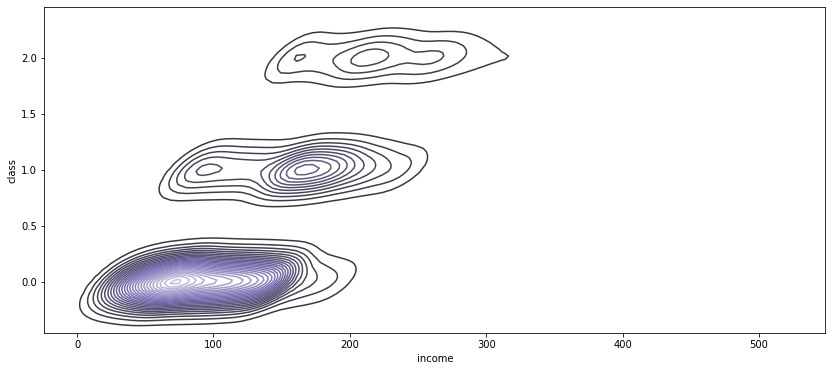

In [10]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (14,6)

sns.kdeplot(df['income'], df['class'], n_levels=30, cmap="Purples_d")

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

outputs = df['segment']
inputs = df[['income', 'response', 'events']]

In [12]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.4, random_state=23)

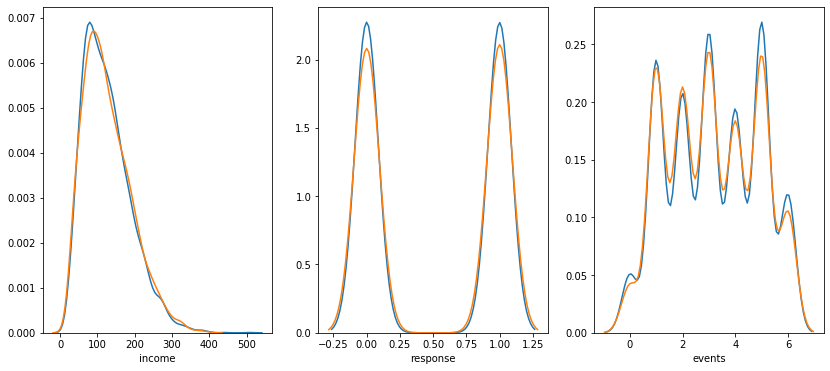

In [13]:
fig, ax =plt.subplots(1,3)
sns.distplot(X_train['income'], hist=False, ax=ax[0])
sns.distplot(X_test['income'], hist=False, ax=ax[0])
sns.distplot(X_train['response'], hist=False, ax=ax[1])
sns.distplot(X_test['response'], hist=False, ax=ax[1])
sns.distplot(X_train['events'], hist=False, ax=ax[2])
sns.distplot(X_test['events'], hist=False, ax=ax[2])
fig.show()

## Train model

In [14]:
from sklearn_pandas import DataFrameMapper

def build_RF_pipeline(inputs, outputs, rf=None):
    if not rf:
        rf = RandomForestClassifier()
    pipeline = Pipeline([
        ("mapper", DataFrameMapper([
            (['response', 'events'], preprocessing.OrdinalEncoder()),
            (['income'], None)
        ])),
        ("classifier", rf)
    ])
    pipeline.fit(inputs, outputs)
    return pipeline

In [28]:
import numpy as np

def RF_estimation(inputs, outputs,
                  estimator_steps=10,
                  depth_steps=10,
                  min_samples_split=None,
                  min_samples_leaf=None):
    # hyper-parameter estimation
    n_estimators = [int(x) for x in np.linspace(start=50, stop=100, num=estimator_steps)]
    max_depth = [int(x) for x in np.linspace(3, 10, num=depth_steps)]
    max_depth.append(None)
    if not min_samples_split:
        min_samples_split = [2, 3, 4]
    if not min_samples_leaf:
        min_samples_leaf = [3, 4, 5]
    bootstrap = [True, False]
    random_grid = {'n_estimators': n_estimators,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

    rf_random = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=random_grid,
                                   n_iter=100, scoring='neg_mean_absolute_error',
                                   cv=3, verbose=1, random_state=42, n_jobs=-1)
    rf_random.fit(inputs, outputs)
    best_random = rf_random.best_estimator_
    print(best_random)
    return (rf_random, best_random)

In [29]:
search, rf = RF_estimation(X_train, y_train, estimator_steps=5, depth_steps=5)
random_forest_pipeline = build_RF_pipeline(X_train, y_train, rf)

rf_predictions = random_forest_pipeline.predict(X_test)
print(f"MSE: {random_forest_pipeline.score(X_test, y_test)*100}%")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.0min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=87,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
MSE: 87.5%


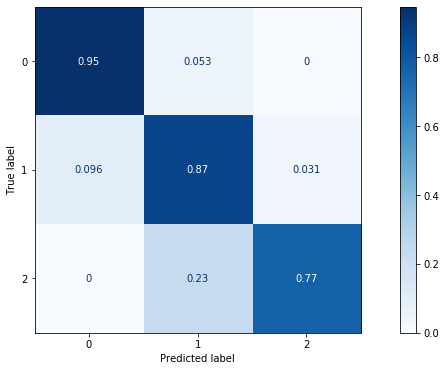

In [36]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(random_forest_pipeline, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

## Export model

In [40]:
import joblib

joblib.dump(random_forest_pipeline, 'model.pkl')

['model.pkl']

In [41]:
import boto3

KEY = "uploaded/model.pkl"

client.upload_file(Bucket=MODEL_BUCKET, Key=KEY, Filename="model.pkl")

PREFIX='OPEN/'

result = client.list_objects(Bucket=MODEL_BUCKET, Prefix=PREFIX, Delimiter='/')

print(result)

{'ResponseMetadata': {'RequestId': 'tx000000000000000000062-005e983925-38a7-my-store', 'HostId': '', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-request-id': 'tx000000000000000000062-005e983925-38a7-my-store', 'content-type': 'application/xml', 'content-length': '292', 'date': 'Thu, 16 Apr 2020 10:53:25 GMT', 'set-cookie': 'b507611c1557e911dd8756816a554169=f21c35af87e0dfc21daf8afac4c9e7ea; path=/; HttpOnly', 'cache-control': 'private'}, 'RetryAttempts': 0}, 'IsTruncated': False, 'Marker': '', 'Name': 'models', 'Prefix': 'OPEN/', 'Delimiter': '/', 'MaxKeys': 1000, 'EncodingType': 'url'}
